In [1]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack
import tempfile
import requests
import warnings

%load_ext autoreload
%autoreload 2

import utils

In [2]:
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/esophagus_muscularis_SM-A8CPH.h5ad"

data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_file = f"{data_folder}/best_cluster.h5ad"

metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_filename = "Cell_metadata.tsv"
metadata_path = f"{data_folder}/catlas_metadata/{metadata_filename}"
ontology_path = f"{data_folder}/Cell_ontology.tsv"
ontology_url = "https://www.ebi.ac.uk/ols4/api/ontologies/cl/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

uropa_path = "/home/stud1/.conda/envs/datenanalyse/bin/uropa"
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/esophagus_muscularis_SM-A8CPH.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/esophagus_muscularis_SM-A8CPH_finalhits.txt"

In [3]:
adata = epi.read_h5ad(h5ad_path)

In [4]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

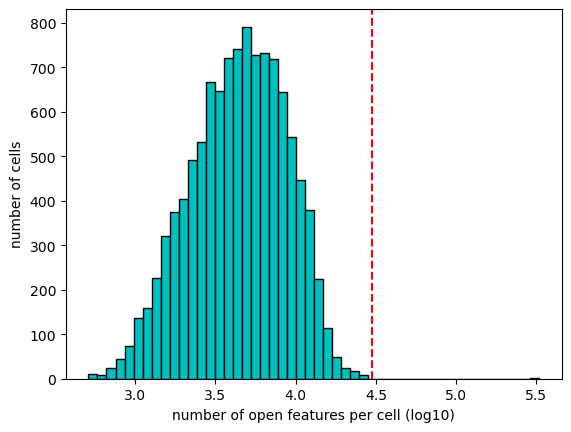

In [5]:
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=30000)

In [6]:
epi.pp.filter_cells(adata, min_features=100)
epi.pp.filter_cells(adata, max_features=30000)

In [7]:
utils.download(metadata_path, metadata_url)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.


In [8]:
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [9]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")

In [10]:
# 10% of all cells:
len(adata.obs["ontology label"])

10996

In [11]:
adata.obs["ontology label"].value_counts()

ontology label
fibroblast                              3201
smooth muscle cell of the esophagus     2686
macrophage                              1943
schwann cell                             579
CD8-positive, alpha-beta T cell          577
smooth muscle cell                       541
pericyte cell                            497
endothelial cell                         345
endothelial cell of lymphatic vessel     183
alveolar macrophage                      156
foveolar cell of stomach                 106
mast cell                                 86
mature NK T cell                          24
naive t cell                              16
cardiac endothelial cell                  10
stromal cell                              10
fibroblast of cardiac tissue               7
luteal cell                                6
enteric smooth muscle cell                 6
plasma cell                                5
CD4-positive, alpha-beta T cell            5
blood vessel smooth muscle cell         

In [12]:
# only keep labels that are bigger than 1% of cell count
threshold = len(adata.obs["ontology label"]) / 100.0
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()
# TODO das Warning beheben ImplicitModificationWarning Transforming to str index.

In [13]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,nb_features,cell type,ontology label,ontology id
16,2410,7.787797,3953.0,8.282483,2410,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
17,4710,8.457655,7891.0,8.973605,4710,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
18,2866,7.961021,4669.0,8.448915,2866,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
19,8464,9.043695,14382.0,9.573802,8464,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
20,8500,9.047939,14767.0,9.600218,8500,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
...,...,...,...,...,...,...,...,...
10988,2470,7.812378,4080.0,8.314097,2470,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10989,2009,7.605890,3399.0,8.131531,2009,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10990,781,6.661855,1282.0,7.156956,781,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10991,1612,7.385851,2685.0,7.895808,1612,Fibroblast (Gastrointestinal),fibroblast,CL:0000057


In [14]:
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [15]:
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [16]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [ ]:
%%time
!{uropa_path} -i {uropa_config}

2024-01-16 18:59:16 (789170) [INFO]	Started UROPA 4.0.3
2024-01-16 18:59:16 (789170) [INFO]	Working directory: /home/stud1/notebooks/release
2024-01-16 18:59:16 (789170) [INFO]	Command-line call: /home/stud1/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmp9vletfu0/config.json
2024-01-16 18:59:16 (789170) [INFO]	Reading configuration from commandline/input config
2024-01-16 18:59:16 (789170) [INFO]	Preparing .gtf-file for fast access
2024-01-16 18:59:53 (789170) [INFO]	Started annotation
2024-01-16 18:59:58 (789170) [INFO]	Progress: Annotated 30000 peaks (1 jobs running; 30 jobs finished)
2024-01-16 19:00:03 (789170) [INFO]	Progress: Annotated 80000 peaks (0 jobs running; 80 jobs finished)
2024-01-16 19:00:08 (789170) [INFO]	Progress: Annotated 130000 peaks (0 jobs running; 130 jobs finished)
2024-01-16 19:00:13 (789170) [INFO]	Progress: Annotated 180000 peaks (0 jobs running; 180 jobs finished)
2024-01-16 19:00:19 (789170) [INFO]	Progress: Annotated 230000 peaks (0 jobs running; 230 jobs

In [ ]:
uropa_df = pd.read_csv(uropa_output, delimiter="\t")
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [ ]:
tmpdirobj.cleanup()

In [ ]:
adata.var

In [ ]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [ ]:
%%time
sc.pp.pca(adata, n_comps=16, use_highly_variable=False)

In [ ]:
sc.pl.pca_overview(adata, color="total_counts")

In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, method='umap', metric='euclidean')

In [ ]:
%%time
sc.tl.umap(adata, min_dist=0.1, spread=2.5)

In [ ]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

In [ ]:
louvain_resolution = 0.25



louvain_tag = f'louvain-R:{louvain_resolution}'

sc.tl.louvain(adata, resolution=louvain_resolution, key_added=louvain_tag)
ari = epi.tl.ARI(adata, louvain_tag, 'ontology label')
ami = epi.tl.AMI(adata, louvain_tag, 'ontology label')

print(f"ARI: {ari}")
print(f"AMI: {ami}")

adata.uns["best_cluster"] = louvain_tag
adata.uns["clusters"] = {
    louvain_tag: {
        "score": {
            "ari": ari,
            "ami": ami
        }
    } 
}

In [ ]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=louvain_tag)

In [ ]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="ontology label")

__Rekey adata.var to genes__

In [ ]:
# remove unannotated regions
adata = adata[:, ~adata.var['gene_name'].isna()]

In [ ]:
duplicated_genes = adata.var['gene_name'][adata.var['gene_name'].duplicated(keep=False)]

In [ ]:
%%time
adata_csc = adata.X.tocsc()

In [ ]:
%%time
merged_data_dict = {}
for gene in duplicated_genes.unique():
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

In [ ]:
%%time
non_duplicated_genes = adata.var['gene_name'][~adata.var['gene_name'].duplicated(keep=False)]
for gene in non_duplicated_genes:
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged_data_dict[gene] = data_slice

In [ ]:
merged_matrix = hstack([l for l in merged_data_dict.values()], format='csr')

In [ ]:
adata_merged = ad.AnnData(X=merged_matrix, obs=adata.obs, obsm=adata.obsm, var=pd.DataFrame(index=merged_data_dict.keys()))

In [ ]:
%%time
adata_merged.write(
        out_file,
        compression="gzip")

In [ ]:
adata_merged